# Imports and Data **Loading** **bold text**

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
from sklearn.decomposition import PCA
import joblib

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/CSE366-AI/Thyroid_Diff.csv')


# **Data Preprocessing**

In [29]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/CSE366-AI/Thyroid_Diff.csv')

# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Print categorical columns
print("Categorical Columns to Encode:")
print(categorical_columns.tolist())

# Encode categorical variables using LabelEncoder
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Define the target column
target_column = 'Recurred'  # Updated target column name

# Ensure that the target column and features are correctly separated
X = data.drop(columns=[target_column])
y = data[target_column]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Proceed with the rest of your code...


Categorical Columns to Encode:
['Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy', 'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred']


#  Model **Initialization**

In [30]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),  # Ensure predict_proba method is available
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(objective='binary:logistic', eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB()
}


# **Model Training and Evaluation**

In [31]:
# Train and evaluate models
results = {}

for name, model in models.items():
    try:
        # Train the model
        model.fit(X_train, y_train)

        # Predict labels
        y_pred = model.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Use predict_proba only if available
        if hasattr(model, "predict_proba"):
            try:
                y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
                roc_auc = roc_auc_score(y_test, y_pred_proba)
            except Exception as proba_error:
                print(f"Warning: Could not compute probabilities for model {name}: {proba_error}")
                y_pred_proba = None
                roc_auc = 'N/A'
        else:
            y_pred_proba = None
            roc_auc = 'N/A'  # Handle models without probability estimates

        # Generate classification report
        report = classification_report(y_test, y_pred, output_dict=True)

        # Store the results
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'report': report
        }

        # Print evaluation metrics
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print(f"ROC-AUC Score: {roc_auc if roc_auc != 'N/A' else 'Not applicable'}")
        print(classification_report(y_test, y_pred))
        print("\n" + "=" * 60 + "\n")

    except Exception as e:
        print(f"Error with model {name}: {e}")
        continue


Model: Logistic Regression
Accuracy: 93.51%
ROC-AUC Score: 0.9346642468239563
              precision    recall  f1-score   support

           0       0.93      0.98      0.96        58
           1       0.94      0.79      0.86        19

    accuracy                           0.94        77
   macro avg       0.94      0.89      0.91        77
weighted avg       0.94      0.94      0.93        77



Model: SVM
Accuracy: 94.81%
ROC-AUC Score: 0.9609800362976406
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        58
           1       0.94      0.84      0.89        19

    accuracy                           0.95        77
   macro avg       0.95      0.91      0.93        77
weighted avg       0.95      0.95      0.95        77



Model: Random Forest
Accuracy: 98.70%
ROC-AUC Score: 0.9954627949183303
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        58
           1       1.

# *ROC Curve Plotting*

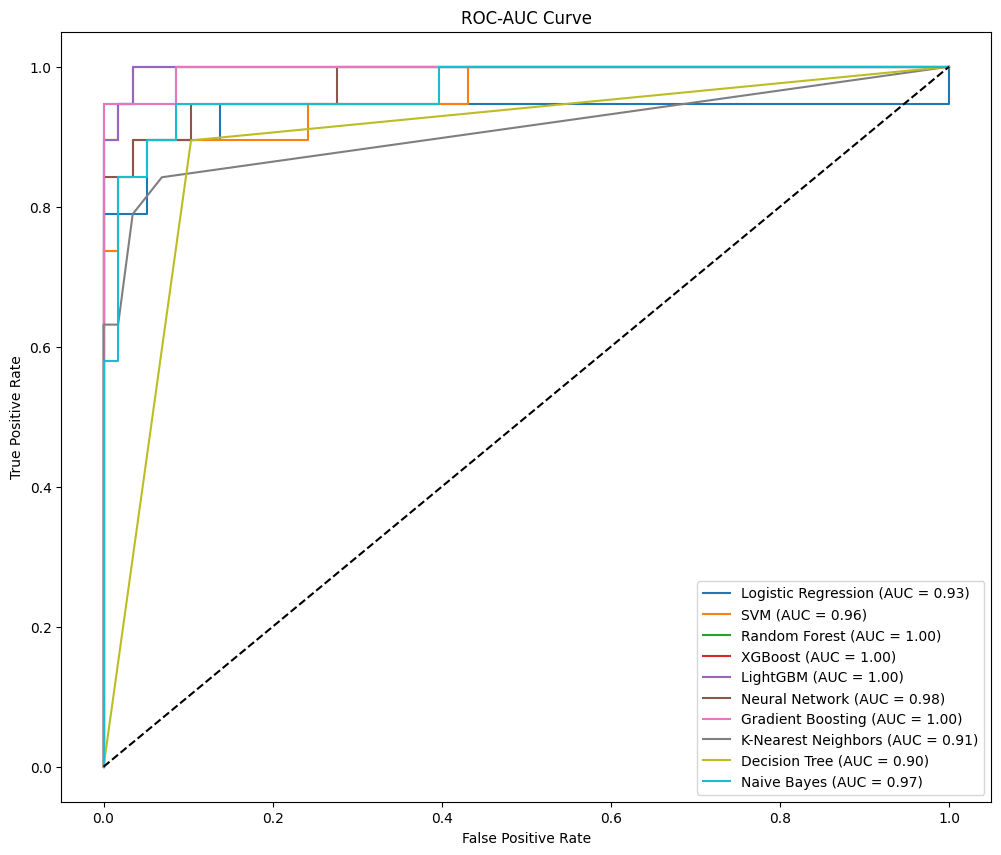

In [32]:
# Plot ROC Curves
plt.figure(figsize=(12, 10))
for name, result in results.items():
    if result['roc_auc'] != 'N/A':
        fpr, tpr, _ = roc_curve(y_test, result['model'].predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='best')
plt.show()


# **Dimensionality Reduction with PCA**

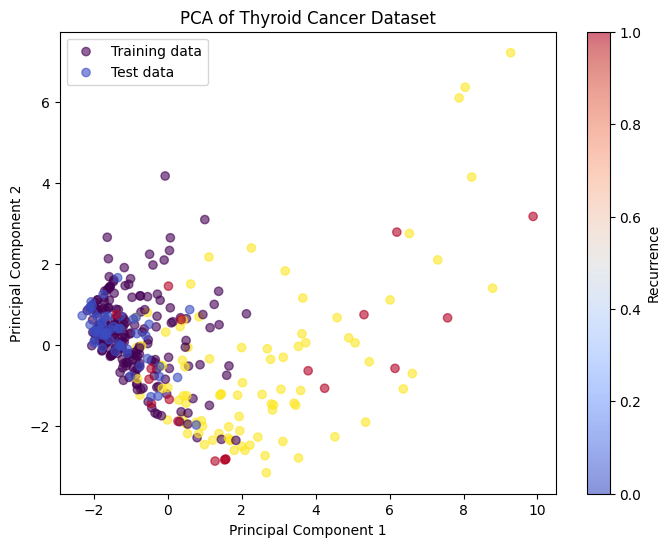

In [33]:
# Apply PCA for dimensionality reduction and plot
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Fit PCA on training data
X_test_pca = pca.transform(X_test)        # Transform test data

plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.6, label='Training data')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', alpha=0.6, label='Test data')
plt.colorbar(label='Recurrence')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Thyroid Cancer Dataset')
plt.legend()
plt.show()


# **Select and Save the Best Model**

In [34]:
# Select the best model
best_model_name = max(results, key=lambda name: results[name]['roc_auc'] if results[name]['roc_auc'] != 'N/A' else -1)
best_model = results[best_model_name]['model']
print(f"Best Model: {best_model_name}")

# Save the best model
joblib.dump(best_model, 'best_dtc_model.pkl')


Best Model: LightGBM


['best_dtc_model.pkl']

# **Load and Evaluate the Best Model**

In [35]:
# Load the saved model
loaded_model = joblib.load('best_dtc_model.pkl')

# Generate predictions with the best model
y_pred_best = loaded_model.predict(X_test)
y_pred_proba_best = loaded_model.predict_proba(X_test)[:, 1]

# Print predictions and evaluation metrics
print(f"Predictions with the best model:\n{y_pred_best}")
print(f"Prediction probabilities:\n{y_pred_proba_best}")

# Evaluation of the loaded model
accuracy_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)
print(f"Best Model Accuracy: {accuracy_best * 100:.2f}%")
print(f"Best Model ROC-AUC Score: {roc_auc_best:.2f}")
print(classification_report(y_test, y_pred_best))


Predictions with the best model:
[0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0
 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0
 0 1 0]
Prediction probabilities:
[6.94649955e-05 3.93462787e-05 9.98125528e-01 8.98401732e-01
 1.34444350e-04 9.93235843e-01 7.51493594e-04 2.80716422e-05
 9.99361784e-01 6.60608517e-01 7.44871874e-01 2.51201620e-05
 5.97719095e-03 7.52809826e-04 5.14092451e-05 1.84056446e-04
 5.73666754e-05 9.99677367e-01 9.97588576e-01 1.60100756e-05
 8.80373562e-05 1.22832992e-03 1.15331812e-04 8.66250638e-04
 1.98530045e-03 2.45697315e-03 1.95707140e-05 3.10852607e-02
 2.54312951e-03 9.60998451e-01 1.76416665e-03 2.33954211e-04
 9.49117943e-01 1.13610691e-03 3.04292312e-05 9.53801079e-01
 1.15638549e-04 3.46917938e-03 9.98368509e-01 9.97947973e-01
 8.70014622e-05 3.04292312e-05 1.04114870e-04 4.57429486e-05
 4.88097046e-03 4.07826501e-03 3.87378674e-05 8.65772602e-05
 9.99051264e-01 1.28686434e-04 3.35999920e-04 2.266